# Integrated Gradients : IG

입력된 설명 변수에 대해 미분 가능한 모델에 적용할 수 있는 Local Explainer이다.

장점
- **IG** 계산을 위해 별도의 학습데이터 불필요
- *pertubation*을 위한 별도의 모델이나 데이터 셋 불필요

단점
- **baseline**의 선택에 따라 설명 변수의 기여도 상이

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● baseline</strong><br>
    예측 중립적인 값으로 예측치에 영향을 미치치 않는 값을 의미한다.<br>
    baseline에 대한 예시는 선형회귀모델에서 0값, 다중분류 task에서 모든 label의 확률을 동일하게 만드는 입력 등이 있다.<br><br>
    <strong style="font-weight: bold;">일반적인 baseline 선택의 예시</strong><br>
    - <strong>tabular</strong>: 각 설명 변수의 평균 혹은 중위수<br>
    - <strong>text</strong>: &ltunknown&gt<br>
    - <strong>image</strong>: 배경색<br>
</div>

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● pertubation(교란)</strong><br>
    입력 데이터나 모델에 작은 변경을 가해 이에 대한 반응을 관찰하는 것<br>
    LIME, SHAP 등에 적용된다.
</div>

---

$$
f(\boldsymbol{x_i})=\beta_{0}+\beta_{1}x_{1}+\cdots+\beta_{j}x_{j}+\cdots+\beta_{p}x_{p}
$$

선형회귀모델에서 $i$번째 표본에 대한 $j$번째 설명 변수 $x_{j}$가 예측치에 미치는 영향은
$
\frac{\partial{f(\boldsymbol{x_i})}}{\partial{x_{ji}}} = \beta_j
$
이므로
$
\beta_{j} x_{ji}
$
가 된다. **baseline**($x_{0j}$) 대비 $x_{ji}$의 기여도(contribution)는 $\beta_{j}(x_{ji}-x_{0j})$이다.


**IG**가 제안된 배경은 비선형 함수에서 위와 같이 gradient와 입력값의 곱으로 계산된 기여도가 왜곡된 결과를 초래하기 때문이다. 다음 단순화된 모델을 예시로 설명한다.

$$
f(x) =
\begin{cases}
    x & ,\text{if } x < 0.8 \\
    0.8 & ,\text{otherwise } 
\end{cases}
$$


<div style="text-align: center;">
  <img src="https://www.tensorflow.org/static/tutorials/interpretability/integrated_gradients_files/output_kMdAKooulVRE_0.png?hl=ko" alt="이미지 설명" />
  <p style="font-size: 12px; color: grey; text-align: center;">
    <em>
        <a href="https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=ko">
            출처: TensorFlow Tutorials IG
        </a>
    </em>
  </p>
</div>

이진분류 task로 좌측 그림은 입력값별 모델의 출력을 시각화하고 있다. 입력값 $x$는 pixel value로 표현되었다. baseline을 0으로 상정하고 앞선 방식으로 x의 기여도를 0.6과 0.8에 대해 계산하면 아래와 같이 0.6의 기여도가 더 큰 것을 알 수 있다. 그러나, 입력값이 0.8인 경우가 모델의 양성 예측 확률을 80%로 만들기 때문에, 0.8인 경우의 기여도가 더 높다. 실제로 높은 기여도를 가진 값이 더 낮은 기여도를 갖고 있다고 왜곡하는 결과를 도출한 것을 확인할 수 있다.
$$
\frac{\partial{f(x)}}{\partial{x}}\times(x-x_0) =
\begin{cases}
    0.6 & ,\text{if } x = 0.6, \\
    0 & ,\text{if } x = 0.8
\end{cases}\\
\text{where } x_0 = 0\\
$$


IG는 해당 문제를 해결하기 위해 특정 값에서의 gradient 대신 baseline과 입력값 사이 구간의 gradient의 평균을 사용한다.

---

## IG의 정의 및 추정

### Path Integration

IG를 이해하기 위해 먼저 *path integration*에 대해 알아야 한다.

$$
\begin{align*}
\int_{C}f(\boldsymbol{x})ds
&=\int_{t_0}^{t_1}f(\boldsymbol{r}(t))\|\boldsymbol{r}'(t)\|dt\\
&=\int_{t_0}^{t_1}f(x_1(t), x_2(t), x_3(t),...)\left\|\frac{\partial{\boldsymbol{r}}}{\partial t}\right\|dt
\end{align*}
$$

곡선 $C$에 대하여 스칼라 함수 $f(\boldsymbol{x})$를 적분한다.<br>
$C$는 $t$를 이용하여 매개변수화 되어 있으며 $\boldsymbol{r}(t)$로 표현된다.<br>
$\boldsymbol{r}(t) = [x_1(t), x_2(t), x_3(t), ...]$<br>
$\|r'(t)\|$는 Jacobian이다.

위치에 따른 특정 물리량($f$)의 누적합을 계산한다고 이해할 수 있다.<br>
함수에 대입없이 Jacobian만 사용하여 경로 적분하면, 아래의 그림처럼 곡선의 시작점과 끝점사이의 최단경로를 구한다고 이해할 수 있다.
<div style="text-align: center;">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Path_integration_diagram.svg/390px-Path_integration_diagram.svg.png" alt="이미지 설명" />
  <p style="font-size: 12px; color: grey; text-align: center;">
    <em>
        <a href="https://en.wikipedia.org/wiki/Path_integration">
            출처: Wikipedia- Path integration
        </a>
    </em>
  </p>
</div>

#### Completeness Property

Path Integration은 Completeness 성질을 만족하며, 초기상태와 경로에 따른 변화량의 합은 최종 상태를 결정한다는 것을 의미한다.
$$
f(\boldsymbol{r}(t_1))=f(\boldsymbol{r}(t_0))+\int_{t_0}^{t_1}f(\boldsymbol{r}(t))\|\boldsymbol{r}'(t)\|dt\\
$$

### IG의 정의

IG의 정의는 다음과 같다.<br>
$x_{0j}$ 는 $j$번째 설명변수의 baseline값, $f$는 예측 모델,
$\frac{\partial{f(x_{j}^{'})}}{\partial{x_{j}}}$
는 
$\frac{\partial{f(x_{j})}}{\partial{x_{j}}}|_{x_{j}=x_{j}^{'}}$ 를 의미한다.

$$
IG(x_j) = (x_{j} - x_{0j}) \int_{0}^{1} \frac {\partial{f(x_{0j} + \alpha (x_{j} - x_{0j}) )}} {\partial{x_{j}}} d\alpha \\
$$



Path Integration의 정의에서 Jacobian만 사용되었고, 매개변수 $\alpha$로 표현된 경로 $x_{0j} + \alpha (x_{j} - x_{0j})$의 길이이다.<br>
특정 구간(경로)에서의 설명 변수 $x_j$의 기여도로 이해할 수 있다.<br>
여기서 구간은 baseline과 x_j로 구성되므로 baseline 대비 기여도이다.<br>
선형 회귀 모델을 $f$에 대입한 후 $\alpha (x_{j} - x_{0j})$를 $w_j$로 치환하여 계산하면 앞선 기여도가 도출된다.

$$
\begin{align*}
IG(x_j) &= 
(x_j - x_{0j})\int_{0}^{1}\frac {\partial{f(x_{0j} + \alpha (x_{j} - x_{0j}) )}} {\partial{x_{j}}} d\alpha \\
&= (x_j - x_{0j}) \int_{x_{0j}}^{x_j} \frac{\partial f(w_j)}{\partial w_j}
\left| \frac{d\alpha}{dw_j} \right|dw_j \\
&= (x_j - x_{0j}) \int_{x_{0j}}^{x_j} \frac{\partial f(w_j)}{\partial w_j}
(x_j-x_{0j})^{-1}dw_j \\
&= \int_{x_{0j}}^{x_j} \frac{\partial f(w_j)}{\partial w_j}dw_j
= \int_{x_{0j}}^{x_j} \beta_j dw_j
= (x_j-x_{0j})\beta_j

\end{align*}


$$

Path Integration의 Completeness 성질에 의해 다음이 성립된다.

$$
\sum_{j=1}^{k}IG(x_j)=f(\boldsymbol{x})-f(\boldsymbol{x}_0)
$$

### IG의 추정

IG는 다음과 같이 Riemann 적분의 근사치로 추정할 수 있다.

$$
\widehat{IG}(x_j) \approx (x_j - x_{0j})\sum_{k=1}^{m}
\frac {\partial{f(x_{0j} + \frac{k}{m} (x_{j} - x_{0j}) )}} {\partial{x_{j}}}
\frac{1}{m}
$$

이에 따라 모델 $f$의 미분의 평균값으로 해석할 수 있다.

## IG의 적용

IG는 ALIBI 라이브러리에서 사용할 수 있으며 입력 옵션은 다음과 같다.
```
IntegratedGradients(model,
                    layer=None,
                    target_fn=None,
                    method="gausslegendre",
                    n_steps=50
                    )
```
`model`은 학습된 모델이고, `layer`에 딥러닝 layer 이름을 지정하면 해당 layer의 IG를 계산한다. 기본값인 `None`을 적용하면 입력층의 설명 변수의 IG를 계산한다.<br>
`target_fn`은 회귀와 같이 하나의 출력이면 기본값인 `None`으로 지정하면 되지만, 분류와 같이 2개 이상의 출력이 있을 때는 별도의 target_fn을 지정해야 한다.<br>
`method`는 IG의 근사방법을 지정하며 `'riemann_left'`, `'riemann_right'`, `'riemann_middel'`, `'riemann_trapzoid'`, `'gausslegendre'` 등을 선택할 수 있다.<br>
`n_steps`는 baseline으로부터 path integration의 $\alpha$를 근사할 때 사용하는 $\frac{k}{m}$에서 $m$을 의미한다.

IG 값은 `explain` 함수로 계산되며 `attributions` 속성으로 접근할 수 있다.

```
ig = IntegratedGradients(model=model)
explaination = ig.explain(X, baseline=None, target=predictions)
attributions = explaination.attributions
```

`X`는 IG를 구할 표본들이며, `baseline=None`으로 지정하면 baseline 값을 0으로 놓게 된다.<br>
IG 객체화 시 `target_fn`을 `None`으로 전달하고 `explain` 메서드의 인자로 **예측값**을 직접적으로 전달해도 된다.


<a href="https://docs.seldon.io/projects/alibi/en/latest/methods/IntegratedGradients.html">IntegratedGradients API Docs</a>

In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt

1에서 10의 손글씨 이미지 데이터인 MNIST 데이터를 불러와, 학습데이터와 시험데이터를 분리하고 데이터를 표준화한다.

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

test_labels = y_test.copy()
train_labels = y_train.copy()

X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


숫자 분류를 위한 딥러닝 모델을 선언하고 학습시킨다.

In [6]:
inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Conv2D(32, 2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
logits = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=logits)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
model.fit(X_train, y_train, epochs=6, batch_size=256, verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7136 - loss: 0.8936 - val_accuracy: 0.9604 - val_loss: 0.1327
Epoch 2/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9383 - loss: 0.1960 - val_accuracy: 0.9769 - val_loss: 0.0739
Epoch 3/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9582 - loss: 0.1350 - val_accuracy: 0.9829 - val_loss: 0.0559
Epoch 4/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9670 - loss: 0.1048 - val_accuracy: 0.9840 - val_loss: 0.0500
Epoch 5/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9707 - loss: 0.0945 - val_accuracy: 0.9859 - val_loss: 0.0407
Epoch 6/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9735 - loss: 0.0818 - val_accuracy: 0.9876 - val_loss: 0.0400


최초 10개의 시험데이터에 대해 IG를 산출하여 설명변수(픽셀)의 기여도를 예측범주의 관점에서 살펴보기 위해 target을 predictions로 지정하고 있다.

In [9]:
X_test_sample = X_test[:10]
predictions = model.predict(X_test_sample).argmax(axis = 1)

ig = IntegratedGradients(model)
explanation = ig.explain(X_test_sample, baselines=None, target=predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


2025-01-27 14:45:07.231312: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


`ig.explain()` 메서드로 반환된 `explanation` 객체의 `meta`속성을 확인하여 다양한 설정값을 확인할 수 있다.

In [10]:
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'target_fn': None,
  'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 'unspecified'},
 'version': '0.9.6'}

`explanation.data.keys()`로 `explanation`에서 확인할 수 있는 데이터의 key값을 파악할 수 있다.

In [11]:
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

`attributions`는 표본 하나당 28 $\times$ 28 픽셀 각각의 basline 대비 기여도를 제공한다.

basline은 각 표본의 크기인 (28, 28, 1) 3D 텐서와 차원이 일치하는 것을 확인할 수 있고, 모든 픽셀값이 검은색인 0으로 구성되어 있는 것을 확인할 수 있다.

In [12]:
attrs = explanation.attributions[0]
print(attrs.shape)
print(attrs.min(), attrs.max())

base=explanation.baselines[0]
print(base.shape)
print(np.unique(base))

(10, 28, 28, 1)
-0.13427369479583687 0.11653441131673371
(28, 28, 1)
[0.]


다음은 앞선 10개의 표본 중 3개의 표본에 있는 각 픽셀의 양의 기여도와 음의 기여도를 그림을 통해 보여주고 있다.

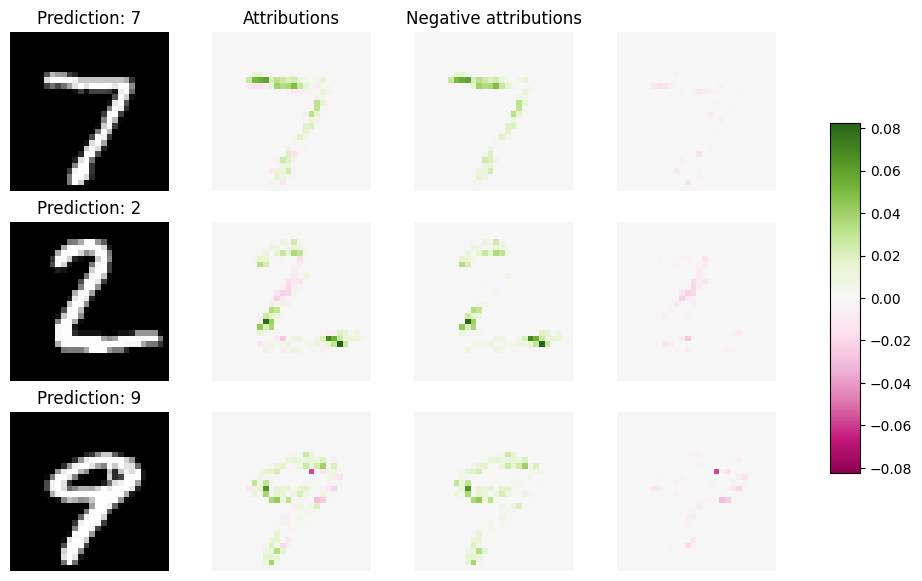

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
image_ids = [0, 1, 9]
cmap_bound = np.abs(attrs[image_ids]).max()

for row, image_id in enumerate(image_ids):
    # original images
    ax[row, 0].imshow(X_test[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f"Prediction: {predictions[image_id]}")

    # attributions
    attr = attrs[image_id]
    img = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # positive attributions
    attr_pos = attr.clip(0, 1)
    img_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

    # negative attributions
    attr_neg = attr.clip(-1, 0)
    img_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')

ax[0, 1].set_title("Attributions")
ax[0, 2].set_title("Positive attributions")
ax[0, 2].set_title("Negative attributions")

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(img, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]))
plt.show()

---

다음은 ResNet50에 4개의 고양이 이미지를 입력하여 이미지를 식별하고 IG를 산출하는 예제이다.

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from alibi.datasets import load_cats

from alibi.explainers import IntegratedGradients
from alibi.utils import visualize_image_attr

In [7]:
image_shape = (224, 224, 3)
data, labels = load_cats(target_size=image_shape[:2], return_X_y=True)

data = (data / 255).astype('float32')

print(f"Images shape: {data.shape}")

Images shape: (4, 224, 224, 3)


최초 4개의 고양이 이미지는 다음과 같다.

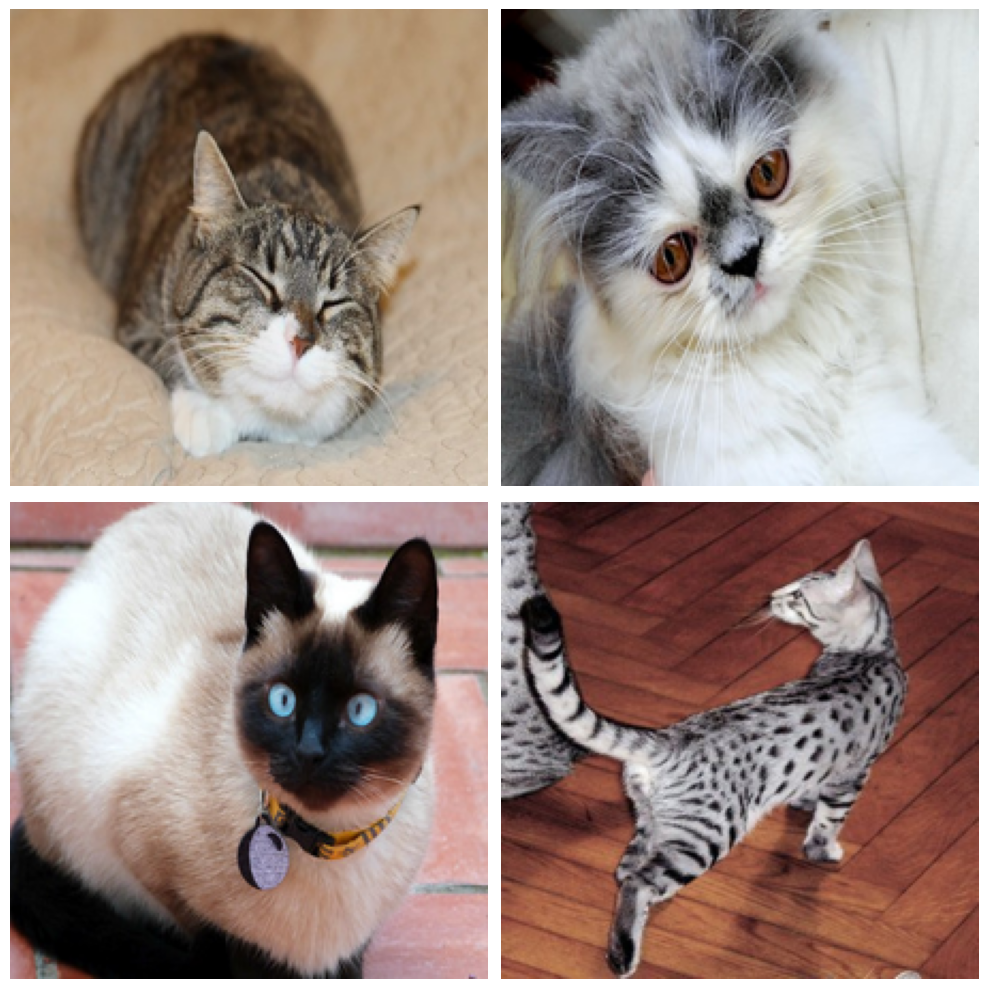

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(data[i])
    ax.axis('off')

fig.tight_layout()
plt.show()

ImageNet 데이터셋에 대해 사전 학습된 ResNet50 모델을 선언하고, 네 번째 고양이 이미지를 입력하여 예측치를 정의한다. 이 후 픽셀 기여도를 산출하고 있다.

In [ ]:
model = ResNet50(weights='imagenet')

ig = IntegratedGradients(model)

i = 3
instance = data[i].reshape((1,) + image_shape)
predictions = model.predict(instance).argmax(axis=1)
explanation = ig.explain(instance, baselines=None, target=predictions)

print(explanation.data.keys())
attrs = explanation.attributions[0]
print(attr.shape)
print(attr.min(), attr.max())